# LeNet

In [11]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 网络架构

In [12]:
# 定义网络结构
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        # 第一层卷积层
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # 第二层卷积层
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # 全连接层
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.avgpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.avgpool2(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        
        return x
            

In [13]:
model = LeNet()
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# 训练函数

In [24]:
def train(net,train_data,valid_data,epochs,optimizer,criterion):

    train_loss_history = []
    valid_loss_history = []

    # 训练部分
    for i in range(epochs):
        train_loss = 0
        train_acc = 0 
        net.train() # 切换为训练模式
        for i,data in enumerate(train_data):
            inputs,labels = data # 获取数据，分别为输入和标签
            inputs,labels = inputs.to(device),labels.to(device) 
            optimizer.zero_grad() # 梯度清零
            outputs = net(inputs) # 前向传播

            loss = criterion(outputs,labels) # 计算损失
            loss.backward() # 反向传播
            optimizer.step() # 更新参数
            train_loss += loss.item() # 累加损失

            _,pred = outputs.max(1) # 找到概率最大的下标，即预测的类别，返回的是最大值和最大值的下标
            num_correct = (pred == labels).sum().item() # 计算正确的个数
            acc = num_correct / inputs.shape[0] # 计算精度
            train_acc += acc # 累加精度
        
        train_loss_history.append(train_loss/len(train_data))
            
        print("epoch:{},train_loss:{:.4f},train_acc:{:.4f}".format(i+1,train_loss/len(train_data),train_acc/len(train_data)))

        # 验证部分
        valid_loss = 0
        valid_acc = 0
        net.eval() # 验证模式
        for i,data in enumerate(valid_data):
            inputs,labels = data
            outputs = net(inputs)
            loss = criterion(outputs,labels)
            valid_loss += loss.item()

            _,pred = outputs.max(1)
            num_correct = (pred == labels).sum().item()
            acc = num_correct / inputs.shape[0]
            valid_acc += acc
        
        valid_loss_history.append(valid_loss/len(valid_data))

        print("epoch:{},valid_loss:{:.4f},valid_acc:{:.4f}".format(i+1,valid_loss/len(valid_data),valid_acc/len(valid_data)))
    
    # 可视化    
    plt.plot(train_loss_history)
    plt.plot(valid_loss_history)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train','valid'])
    plt.show()
        


# 定义超参数及损失函数

In [15]:
# 定义超参数
epochs = 5
lr = 0.001
batch_size = 64

# 定义优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

# 定义设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 定义训练集和测试集

In [21]:
'''
在LeNet模型中，对输入数据集的预处理主要包括以下两个步骤：
将输入图像调整为32x32大小
将输入图像归一化到[-1, 1]范围内
'''
# 定义数据预处理
transform = transforms.Compose([
    transforms.Resize((32, 32)), # 将图像调整为32x32大小
    transforms.ToTensor(),      # 将图像转换为Tensor格式
    transforms.Normalize(mean=(0.5,), std=(0.5,)) # 将图像归一化到[-1, 1]范围内
])


# 定义训练集
train_data = torchvision.datasets.MNIST(root="./data",
                                        train=True,
                                        transform=transform,
                                        download=True)

# 验证集，用于验证模型的泛化能力，不参与训练
valid_data = torchvision.datasets.MNIST(root="./data",
                                        train=False,
                                        transform=transform,
                                        download=True)

# 定义数据加载器，用于把数据分成多个batch，每个batch的数量为batch_size
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size=batch_size,
                                           shuffle=False)

# 调整dataset的大小
train_data_size = len(train_data)
valid_data_size = len(valid_data)



epoch:938,train_loss:0.0172,train_acc:0.9945
epoch:157,valid_loss:0.0265,valid_acc:0.9918
epoch:938,train_loss:0.0145,train_acc:0.9952
epoch:157,valid_loss:0.0274,valid_acc:0.9911
epoch:938,train_loss:0.0137,train_acc:0.9955
epoch:157,valid_loss:0.0269,valid_acc:0.9924
epoch:938,train_loss:0.0128,train_acc:0.9958
epoch:157,valid_loss:0.0334,valid_acc:0.9905
epoch:938,train_loss:0.0110,train_acc:0.9965
epoch:157,valid_loss:0.0297,valid_acc:0.9917


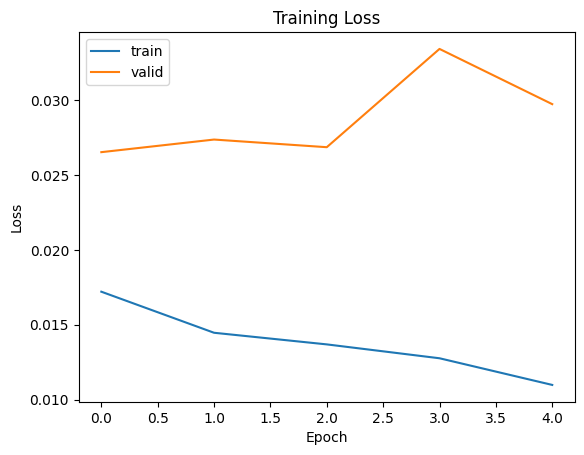

In [25]:
# 开始训练
train(model,train_loader,valid_loader,epochs,optimizer,criterion)

# 保存模型，加载模型，使用模型

In [26]:
# 保存模型
torch.save(model.state_dict(),"./model/lenet.pth")

In [27]:
# 加载模型
model.load_state_dict(torch.load("./model/lenet.pth"))

<All keys matched successfully>

In [29]:
# 测试模型
test_data = torchvision.datasets.MNIST(root="./data",train=False,transform=transform,download=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=batch_size,shuffle=False)

test_acc = 0
model.eval() # 测试模式
for i,data in enumerate(test_loader):
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    _,pred = outputs.max(1)
    num_correct = (pred == labels).sum().item()
    acc = num_correct / inputs.shape[0]
    test_acc += acc

print("test_acc:{:.4f}".format(test_acc/len(test_loader)))

test_acc:0.9917


预测结果： tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])
真实结果： tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])


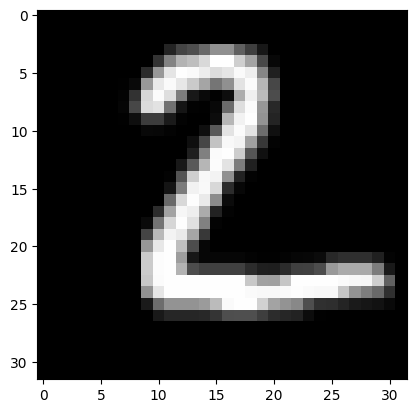

In [32]:
# 预测
model.eval()
dataiter = iter(test_loader)
images,labels = next(dataiter)
images,labels = images.to(device),labels.to(device)
outputs = model(images)
_,pred = outputs.max(1)
print("预测结果：",pred)
print("真实结果：",labels)

# 可视化
plt.imshow(images[1].cpu().numpy().squeeze(),cmap="gray")
plt.show()
